## Diffusion Models Beat GANs on Image Synthesis

환경 준비: 최신 라이브러리 설치 및 레포 클론, 메모리 관련 환경 변수 설정

공통 유틸: 시드, 디바이스, 저장/시각화 함수

데이터셋: CIFAR-10을 64x64로 리사이즈 및 [-1,1] 정규화

모델/디퓨전: guided_diffusion.script_util을 이용하되 저메모리 설정(채널/블록 축소, use_checkpoint=True 등)

콜백 구현: LoggerTable/Checkpoint/Sampler

학습 루프: 마이크로배치 + AMP + 스케줄 샘플러 + 주기적 empty_cache

샘플링 함수: 수동 DDPM/DDIM
Real vs Generated 비교 시각화 셀

경량 평가(FID/IS)
체크포인트 저장/로드

In [1]:
# Cell 1: 환경 설정 & 레포 클론 (저메모리 설정 반영)
# - pip 최신화 및 필요한 라이브러리 설치
# - 메모리 단편화 방지를 위한 환경 변수 설정
# - guided-diffusion 레포 클론 및 파이썬 경로 추가
# - Torch/CUDA 버전 출력

# # 최신 pip로 업그레이드 (패키지 설치 안정성 향상)
# !pip -q install --upgrade pip

# # CUDA 12.1에 맞춘 최신 PyTorch/torchvision 설치 (Colab 런타임과 맞추기)
# !pip -q install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# 실습에 필요한 기타 라이브러리 설치 (시각화/평가/진행바 등)
# !pip -q install --upgrade einops pandas matplotlib seaborn tqdm pillow torchmetrics

!pip -q install --upgrade torchmetrics

# 메모리 단편화 방지: PyTorch CUDA allocator에 expandable_segments 활성화 (OOM/조각화 예방)
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# guided-diffusion 레포가 없으면 클론
import sys, subprocess, pathlib
if not pathlib.Path("guided-diffusion").exists():
    !git clone https://github.com/openai/guided-diffusion.git

# 파이썬 경로에 레포 추가 (모듈 임포트 가능하도록)
sys.path.append(str(pathlib.Path("guided-diffusion").resolve()))

# 버전 출력 (디버깅/재현성)
import torch, torchvision
print("Python version:", sys.version)
print("Torch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())
print("Torchvision:", torchvision.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 24.3 MB/s eta 0:00:00
Cloning into 'guided-diffusion'...
remote: Enumerating objects: 113, done.
remote: Total 113 (delta 0), reused 0 (delta 0), pack-reused 113 (from 1)
Receiving objects: 100% (113/113), 67.86 KiB | 6.79 MiB/s, done.
Resolving deltas: 100% (47/47), done.
Python version: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Torch: 2.8.0+cu126 | CUDA available: True
Torchvision: 0.23.0+cu126


환경 설정 및 레포 클론(메모리 환경 변수 포함)



In [2]:
# Cell 2: 레포 핵심 파일 존재/크기 확인 (컨텍스트 점검)
from pathlib import Path
root = Path("guided-diffusion")
key_files = [
    "guided_diffusion/script_util.py",   # 모델/디퓨전 생성 유틸
    "guided_diffusion/train_util.py",    # 공식 학습 루프(DDP 등)
    "guided_diffusion/image_datasets.py",# 공식 데이터 로더(MPI 가정)
    "scripts/image_train.py",            # 학습 스크립트 예시
    "scripts/classifier_train.py",       # 분류기 학습 예시
    "evaluations/evaluator.py",          # 공식 평가(TF Inception)
]
for f in key_files:
    p = root / f
    print(f"- {f}: exists={p.exists()}, size={p.stat().st_size if p.exists() else 0}")

- guided_diffusion/script_util.py: exists=True, size=12349
- guided_diffusion/train_util.py: exists=True, size=10604
- guided_diffusion/image_datasets.py: exists=True, size=5930
- scripts/image_train.py: exists=True, size=2298
- scripts/classifier_train.py: exists=True, size=7313
- evaluations/evaluator.py: exists=True, size=25057


레포지토리 핵심 파일 확인

In [3]:
# Cell 3: 공통 설정/유틸
# - 시드 고정(재현성)
# - 디바이스 설정 (CUDA 있으면 cuda)
# - 이미지 그리드 생성/저장/표시 유틸
# - torch.amp.autocast (신규 API) 사용을 위한 플래그
import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from PIL import Image
from IPython.display import display, clear_output

import torch
import torch.nn.functional as F
from torchvision import utils as vutils

# 재현성 위한 시드 고정
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# 디바이스 결정
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 출력/저장 디렉터리 준비
import os
os.makedirs("checkpoints", exist_ok=True)
os.makedirs("samples", exist_ok=True)
os.makedirs("logs", exist_ok=True)

# 이미지 텐서를 그리드로 변환 (시각화/저장용)
def to_grid(imgs, nrow=8, normalize=True, value_range=(-1,1)):
    # [-1,1] 범위를 normalize=True, value_range로 0~1에 맞춰 그리드 생성
    return vutils.make_grid(imgs, nrow=nrow, normalize=normalize, value_range=value_range)

# 그리드를 파일로 저장 (vutils.save_image가 있으나 수동 저장 예시도 제공)
def save_grid(tensor, path):
    # 텐서를 HWC uint8 이미지로 변환 후 저장
    t = tensor
    if t.max() <= 1.0:
        t = (t * 255).clamp(0,255)
    ndarr = t.permute(1,2,0).detach().cpu().numpy().astype(np.uint8)
    Image.fromarray(ndarr).save(path)

# 노트북 안에서 이미지 프리뷰
def show_grid(imgs, nrow=8, title=None):
    grid = to_grid(imgs, nrow=nrow, normalize=True, value_range=(-1,1))
    img = np.clip((grid.permute(1,2,0).cpu().numpy()+1)/2, 0, 1)
    clear_output(wait=True)
    if title:
        print(title)
    display(Image.fromarray((img*255).astype(np.uint8)))

# 최신 권장 API: torch.amp.autocast('cuda', enabled=...)
AMP_ENABLE = torch.cuda.is_available()  # GPU 있으면 AMP 사용 권장(메모리 절감/속도 향상)

공통 설정/유틸(저메모리 최적화 반영)

In [4]:
# Cell 4: 데이터 로더 (CIFAR-10 -> 64x64, [-1,1] 정규화, 작은 배치)
import torchvision
from torchvision import transforms, datasets

# 저메모리 설정: 배치/워커 수를 작게 (OOM 예방)
BATCH_SIZE = 16      # 이전보다 작게 (예: 64 -> 16)
MICROBATCH = 8       # 마이크로배치(그래디언트 누적): VRAM 더 절약
IMAGE_SIZE = 64      # guided-diffusion 모델이 지원하는 최소 해상도(64)
NUM_WORKERS = 2      # Colab 기본에 적합

# CIFAR-10 이미지를 64x64로 리사이즈하고 [-1,1]로 정규화
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=transforms.InterpolationMode.BICUBIC),  # 64x64 업샘플
    transforms.ToTensor(),                   # [0,1]
    transforms.Lambda(lambda x: x*2.0 - 1.0) # [-1,1]
])

# 학습/검증 데이터 다운로드 및 로더 생성
train_ds = datasets.CIFAR10(root="./data", train=True,  download=True, transform=transform)
val_ds   = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

# DataLoader에서 pin_memory=True로 H2D 전송 최적화(있으면)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = torch.utils.data.DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

len(train_ds), len(val_ds)

100%|██████████| 170M/170M [00:07<00:00, 22.7MB/s]


(50000, 10000)

데이터셋 준비(CIFAR-10 → 64x64, 저메모리 배치)

In [5]:
# Cell 5: 모델/디퓨전/스케줄 생성 (저메모리 구성)
from guided_diffusion.script_util import (
    create_model_and_diffusion,
    model_and_diffusion_defaults,
)
from guided_diffusion.resample import create_named_schedule_sampler

# 기본 하이퍼파라미터 로드
defaults = model_and_diffusion_defaults()

# 저메모리 설정으로 업데이트
defaults.update(dict(
    image_size=IMAGE_SIZE,     # 64
    class_cond=False,          # 무조건 모델(라벨 입력 없음)
    learn_sigma=True,         # 시그마 학습 비활성화 → 출력 채널 절반, 메모리 절감
    use_scale_shift_norm=True,
    resblock_updown=True,
    num_channels=128,           # 채널 수 축소(메모리 절감)
    num_res_blocks=2,          # ResBlock 개수 축소(메모리/연산 절감)
    channel_mult="",           # 64에 대한 기본 멀티플(1,2,3,4) 사용
    use_fp16=False,            # UNet 내부 fp16 비활성화(AMP로 관리)
    use_checkpoint=True,       # 그래디언트 체크포인팅 활성화(메모리 절감, 연산 증가)
    dropout=0.0,               # 드롭아웃 기본값
    attention_resolutions="32, 16,8",# 어텐션은 16x16 스케일에서만(과도한 메모리 방지)
    diffusion_steps=1000,      # 표준 DDPM 스텝
    noise_schedule="cosine",   # 표준 노이즈 스케줄
    rescale_timesteps=True,    # 1000 스텝 기준 리스케일
    timestep_respacing="ddim50",     # 전체 스텝 사용(샘플링에서 DDIM 옵션으로 단축 가능),
))

# 모델/디퓨전 생성 및 디바이스 이동
model, diffusion = create_model_and_diffusion(**defaults)
model.to(DEVICE).train()

# 학습용 시간 스케줄 샘플러 (Uniform)
schedule_sampler = create_named_schedule_sampler("uniform", diffusion)

# 옵티마이저: AdamW (저학습률/가중치감쇠 기본)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=0.01)

print("Model and diffusion ready (low-memory config).")

Model and diffusion ready (low-memory config).


모델/디퓨전 생성(저메모리 설정 핵심)



In [6]:
# Cell 6: 콜백 (실시간 로깅/체크포인트/샘플)
import time

class BaseCallback:
    def on_train_begin(self, state): ...
    def on_epoch_begin(self, state): ...
    def on_step_end(self, state): ...
    def on_epoch_end(self, state): ...
    def on_train_end(self, state): ...

class LoggerTableCallback(BaseCallback):
    def __init__(self, every=10, history_csv="logs/history.csv", keep_last=200):
        self.every = every                   # 몇 스텝마다 테이블 업데이트
        self.keep_last = keep_last           # 최근 N개만 표시/저장
        self.history_csv = history_csv       # CSV 저장 경로
        self.records = []                    # 기록 리스트

    def on_train_begin(self, state):
        self.records = []                    # 시작 시 기록 초기화

    def on_step_end(self, state):
        if state['step'] % self.every == 0:  # 지정 주기마다 실행
            rec = dict(
                step=state['step'], epoch=state['epoch'], loss=float(state['loss']),
                lr=float(state['lr']), sec_per_step=round(state['sec_per_step'], 4),
                gpu_mem_mb=round(state['gpu_mem_mb'], 1),
            )
            self.records.append(rec)         # 레코드 추가
            self.records = self.records[-self.keep_last:]  # 최근 keep_last만 유지
            df = pd.DataFrame(self.records)  # 데이터프레임 생성
            clear_output(wait=True)          # 출력 지우기(실시간 업데이트 효과)
            display(df.tail(20).style.hide(axis='index'))  # 최근 20개 표시
            df.to_csv(self.history_csv, index=False)       # CSV로 저장

class CheckpointCallback(BaseCallback):
    def __init__(self, every=200, out_dir="checkpoints"):
        self.every = every                   # 저장 주기
        self.out_dir = out_dir               # 저장 폴더
        os.makedirs(out_dir, exist_ok=True)  # 폴더 생성

    def on_step_end(self, state):
        if state['step'] % self.every == 0 and state['step'] > 0:
            path = os.path.join(self.out_dir, f"model_step_{state['step']:06d}.pt")
            torch.save({'model': state['model'].state_dict()}, path)  # 모델 가중치 저장
            print(f"[Checkpoint] Saved: {path}")

class SamplerCallback(BaseCallback):
    def __init__(self, every=200, num_samples=16, nrow=4, out_dir="samples", use_ddim=True):
        self.every = every               # 샘플 생성 주기
        self.num_samples = num_samples   # 생성 샘플 수(작게 설정하여 VRAM 절약)
        self.nrow = nrow                 # 그리드 열 개수
        self.out_dir = out_dir           # 출력 폴더
        self.use_ddim = use_ddim         # DDIM 사용할지 여부 (DDPM보다 빠르고 덜 noisy)
        os.makedirs(out_dir, exist_ok=True)

    @torch.no_grad()
    def _sample(self, state):
        model = state['model']
        diffusion = state['diffusion']
        bsz = self.num_samples
        shape = (bsz, 3, state['image_size'], state['image_size'])
        model.eval()                                         # eval 모드로 전환(BN/Dropout 고정)
        # DDIM 샘플링(기본 설정); DDPM은 더 느리고 노이즈가 많을 수 있음
        if self.use_ddim:
            imgs = diffusion.ddim_sample_loop(model, shape, clip_denoised=True, device=DEVICE, progress=True)
        else:
            imgs = diffusion.p_sample_loop(model, shape, clip_denoised=True, device=DEVICE, progress=True)
        model.train()                                        # 다시 train 모드
        return imgs

    def on_step_end(self, state):
        if state['step'] % self.every == 0 and state['step'] > 0:
            imgs = self._sample(state)                       # 샘플 생성
            grid = to_grid(imgs, nrow=self.nrow, normalize=True, value_range=(-1,1))
            path = os.path.join(self.out_dir, f"samples_step_{state['step']:06d}.png")
            # vutils.save_image는 [0,1] 범위 텐서를 기대 → [-1,1] 그리드를 [0,1]로 변환 후 저장
            vutils.save_image((grid+1)/2, path)
            print(f"[Samples] Saved: {path}")
            show_grid(imgs, nrow=self.nrow, title=f"Samples @ step {state['step']}")
            # 샘플 생성 후 캐시 정리(메모리 회수)
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

콜백 프레임워크(저메모리 친화적으로 샘플 수 축소)

In [7]:
# Cell 7: 학습 루프 (저메모리/저GPU 구성)
def train(
    model, diffusion, optimizer, schedule_sampler, train_loader,
    epochs=1, max_steps=600, callbacks=None, image_size=IMAGE_SIZE,
    microbatch=MICROBATCH, grad_clip=1.0
):
    model.train()                             # 학습 모드
    step = 0                                  # 전체 스텝 카운터
    callbacks = callbacks or []               # 콜백 리스트 기본값

    # 학습 시작 콜백 호출
    for cb in callbacks:
        cb.on_train_begin(dict(step=step, epoch=0, model=model, diffusion=diffusion, image_size=image_size))

    for epoch in range(1, epochs+1):
        epoch_t0 = time.time()                # 에폭 시간 측정 시작
        for batch in train_loader:
            iter_t0 = time.time()             # 스텝 시간 측정 시작
            imgs = batch[0].to(DEVICE, non_blocking=True)  # 이미지 배치 텐서만 사용(무조건 모델)
            cond = {}                         # 조건 없음

            # 스케줄 샘플러로 타임스텝 t와 가중치 w 샘플
            t_idx, w = schedule_sampler.sample(imgs.shape[0], DEVICE)

            # 그래디언트 초기화
            optimizer.zero_grad(set_to_none=True)

            # 마이크로배치로 나누어 역전파 (OOM 방지)
            losses_accum = 0.0                # 손실 누적(로깅용)
            count_accum  = 0                  # 누적 샘플 수

            # Disable AMP here to avoid the type mismatch
            with torch.amp.autocast('cuda', enabled=False):
                for mb_start in range(0, imgs.shape[0], microbatch):
                    mb_end = min(mb_start + microbatch, imgs.shape[0])
                    micro = imgs[mb_start:mb_end]               # 마이크로배치 슬라이스
                    micro_t = t_idx[mb_start:mb_end]            # 타임스텝 슬라이스
                    micro_w = w[mb_start:mb_end]                # 가중치 슬라이스

                    # guided-diffusion의 training_losses 호출로 손실 계산
                    out = diffusion.training_losses(model, micro, micro_t, model_kwargs=cond)
                    # 손실은 dict이며 대표 키는 "loss", 가중치로 평균
                    loss = (out["loss"] * micro_w).mean()

                    # 역전파
                    loss.backward()

                    # 누적 로깅을 위해 합산
                    losses_accum += float(loss.detach().cpu()) * (mb_end - mb_start)
                    count_accum  += (mb_end - mb_start)

            # 그래디언트 클리핑(폭주 방지/안정화)
            if grad_clip is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

            # 옵티마이저 스텝
            optimizer.step()

            # 스텝 카운트 증가
            step += 1

            # 스텝 시간/메모리/러닝레이트 계산
            iter_t1 = time.time()
            sec_per_step = iter_t1 - iter_t0
            lr = optimizer.param_groups[0]['lr']
            gpu_mem_mb = (torch.cuda.memory_allocated() / (1024**2)) if torch.cuda.is_available() else 0.0

            # 상태 패킷(콜백 전달용)
            state = dict(
                step=step, epoch=epoch,
                loss=(losses_accum / max(1, count_accum)),  # 배치 평균 손실
                lr=lr, sec_per_step=sec_per_step, gpu_mem_mb=gpu_mem_mb,
                model=model, diffusion=diffusion, image_size=image_size
            )

            # 콜백 실행(로깅/체크포인트/샘플 생성 등)
            for cb in callbacks:
                cb.on_step_end(state)

            # 주기적으로 캐시 정리(OOM 예방)
            if torch.cuda.is_available() and (step % 5 == 0):
                torch.cuda.empty_cache()

            # 최대 스텝 도달 시 조기 종료
            if step >= max_steps:
                for cb in callbacks:
                    cb.on_epoch_end(state)
                    cb.on_train_end(state)
                print(f"Train finished: steps={step}, epoch={epoch}, epoch_time={time.time()-epoch_t0:.1f}s")
                return

        # 에폭 종료 시 콜백
        for cb in callbacks:
            cb.on_epoch_end(dict(step=step, epoch=epoch, model=model, diffusion=diffusion, image_size=image_size))

    # 전체 종료 콜백
    for cb in callbacks:
        cb.on_train_end(dict(step=step, epoch=epoch, model=model, diffusion=diffusion, image_size=image_size))

학습 루프(저메모리 핵심: 마이크로배치/AMP/체크포인팅/캐시 비우기)

Samples @ step 1000


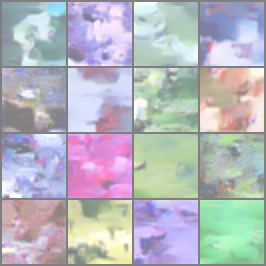

Train finished: steps=1000, epoch=1, epoch_time=1413.2s


In [8]:
# Cell 8: 학습 실행 (저메모리/저GPU)
logger_cb  = LoggerTableCallback(every=10)                                # 10스텝마다 테이블 업데이트
ckpt_cb    = CheckpointCallback(every=200, out_dir="checkpoints")         # 200스텝마다 모델 저장
sample_cb  = SamplerCallback(every=200, num_samples=16, nrow=4, use_ddim=True)  # 200스텝마다 16장 샘플

# 데모: 300~600 스텝 정도면 Colab에서 수십 분 내 실습 가능
train(
    model=model,
    diffusion=diffusion,
    optimizer=optimizer,
    schedule_sampler=schedule_sampler,
    train_loader=train_loader,
    epochs=999,           # max_steps에서 종료
    max_steps=1000,        # 데모 스텝(더 적게도 가능)
    callbacks=[logger_cb, ckpt_cb, sample_cb],
    image_size=IMAGE_SIZE,
    microbatch=MICROBATCH,
    grad_clip=1.0,
)

학습 실행(저메모리 설정)

Manual sampling (DDIM)


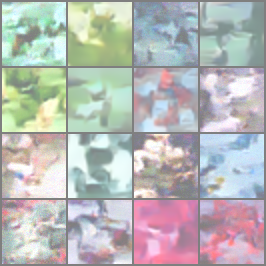

Saved to samples/manual_ddim.png


In [9]:
# Cell 9: 샘플링 수동 실행 (DDIM/혹은 DDPM)
@torch.no_grad()
def generate_samples(model, diffusion, num_samples=16, image_size=IMAGE_SIZE, use_ddim=True):
    model.eval()                                      # eval 모드
    shape = (num_samples, 3, image_size, image_size)  # 생성 텐서 크기
    if use_ddim:
        # DDIM 샘플링 (빠르고 비교적 안정적)
        samples = diffusion.ddim_sample_loop(model, shape, clip_denoised=True, device=DEVICE, progress=True)
    else:
        # DDPM 샘플링 (기본, 더 느릴 수 있음)
        samples = diffusion.p_sample_loop(model, shape, clip_denoised=True, device=DEVICE, progress=True)
    model.train()                                     # 다시 학습 모드
    return samples

# 샘플 생성 & 표시 & 저장
imgs = generate_samples(model, diffusion, num_samples=16, use_ddim=True)
show_grid(imgs, nrow=4, title="Manual sampling (DDIM)")
vutils.save_image((to_grid(imgs, nrow=4, normalize=True, value_range=(-1,1))+1)/2, "samples/manual_ddim.png")
print("Saved to samples/manual_ddim.png")

샘플링(수동) — DDPM/DDIM

In [10]:
# Cell 10: 체크포인트 저장/불러오기
def save_checkpoint(model, path="checkpoints/last.pt"):
    torch.save({'model': model.state_dict()}, path)  # state_dict만 저장(간결/이식성)
    print(f"Saved: {path}")

def load_checkpoint(model, path):
    state = torch.load(path, map_location=DEVICE)    # 해당 디바이스로 로드
    model.load_state_dict(state['model'])            # 가중치 로드
    print(f"Loaded: {path}")

# 마지막 상태 저장
save_checkpoint(model, "checkpoints/last.pt")

# 필요 시 로드 예시:
# load_checkpoint(model, "checkpoints/last.pt")

Saved: checkpoints/last.pt


체크포인트 저장/불러오기

Left: Real | Right: Generated (DDIM)


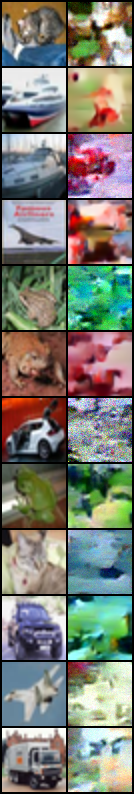

Saved comparison grid to: samples/real_vs_fake.png


In [11]:
# Cell 11: Real vs Generated 비교 시각화
import torch
from torchvision import utils as vutils
import numpy as np
from PIL import Image
from IPython.display import display, clear_output

@torch.no_grad()
def compare_real_and_generated(
    model, diffusion, val_loader, num_pairs=12, use_ddim=True, save_path="samples/real_vs_fake.png"
):
    # 1) Real 이미지 N개 수집 (검증셋에서)
    real_batch = next(iter(val_loader))[0][:num_pairs].to(DEVICE)

    # 2) 동일 개수의 Generated 이미지 생성
    fake_batch = generate_samples(model, diffusion, num_samples=num_pairs, use_ddim=use_ddim)

    # 3) [-1,1] -> [0,1] 변환
    real_01 = (real_batch + 1) / 2
    fake_01 = (fake_batch + 1) / 2

    # 4) Real-Generated 번갈아 2열 그리드로 구성
    pairs = []
    for i in range(num_pairs):
        pairs.append(real_01[i].cpu())
        pairs.append(fake_01[i].cpu())
    comp = torch.stack(pairs, dim=0)  # [2*num_pairs, C, H, W] 형태

    # 2열 그리드 생성 (좌: Real, 우: Generated)
    grid = vutils.make_grid(comp, nrow=2, padding=2)

    # 시각화: [0,1] 범위를 [0,255]로 변환 후 표시
    grid_np = (grid.permute(1, 2, 0).numpy() * 255).clip(0, 255).astype(np.uint8)
    clear_output(wait=True)
    print("Left: Real | Right: Generated (DDIM)" if use_ddim else "Left: Real | Right: Generated (DDPM)")
    display(Image.fromarray(grid_np))

    # 5) 저장
    vutils.save_image(grid, save_path)
    print(f"Saved comparison grid to: {save_path}")

# 실행 예시
compare_real_and_generated(
    model=model,
    diffusion=diffusion,
    val_loader=val_loader,
    num_pairs=12,     # 메모리 고려하여 12쌍(=24장) 표시
    use_ddim=True,    # DDIM 권장
    save_path="samples/real_vs_fake.png"
)

Real vs Generated 비교 시각화(요청하신 추가 셀)

아예 다른 이미지 생성되는 문제.

Loss 값이 갑자기 늘어나는 경우도 있어 Overfitting 의심됨.

사전학습된 모델을 이용하는 것이 성능이 좋을 것.

## Pretrained Model

In [12]:
# Cell 1: 환경 준비 & 레포 클론
# - 최신 PyTorch/torchvision과 기타 도구 설치
# - guided-diffusion 레포를 클론하여 내부 유틸을 임포트 가능하게 설정
# - CUDA/버전 확인

# !pip -q install --upgrade pip
# !pip -q install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip -q install --upgrade einops pandas matplotlib seaborn tqdm pillow

import os, sys, pathlib, torch, torchvision
if not pathlib.Path("guided-diffusion").exists():
    !git clone https://github.com/openai/guided-diffusion.git
sys.path.append(str(pathlib.Path("guided-diffusion").resolve()))

print("Python:", sys.version)
print("Torch:", torch.__version__, "| CUDA:", torch.cuda.is_available())
print("Torchvision:", torchvision.__version__)

Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Torch: 2.8.0+cu126 | CUDA: True
Torchvision: 0.23.0+cu126


In [13]:
# Cell 2: 공통 유틸(시드, 디바이스, 다운로드/시각화 함수)

import random, numpy as np
from PIL import Image
from IPython.display import display, clear_output
from torchvision.utils import make_grid, save_image

# 재현성: 시드 고정
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# 디바이스 선택
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 파일 다운로드 유틸(체크포인트 자동 다운로드에 사용)
import urllib.request
def download_file(url: str, dst_path: str):
    os.makedirs(os.path.dirname(dst_path), exist_ok=True)
    if not os.path.exists(dst_path):
        print(f"Downloading {url} -> {dst_path}")
        urllib.request.urlretrieve(url, dst_path)
    else:
        print(f"Found existing file: {dst_path}")

# 이미지 그리드 시각화
def show_tensor_grid(imgs, nrow=8, title=None, value_range=(-1,1), normalize=True):
    grid = make_grid(imgs, nrow=nrow, normalize=normalize, value_range=value_range)
    grid_np = (grid.permute(1,2,0).cpu().numpy())
    if normalize and value_range==(-1,1):
        grid_np = np.clip((grid_np+1)/2, 0, 1)
    clear_output(wait=True)
    if title:
        print(title)
    display(Image.fromarray((grid_np*255).astype(np.uint8)))

In [14]:
# Cell 3: 데이터셋(CIFAR-10 → 64x64, [-1,1]) 준비
# - 사전학습 모델은 ImageNet(64x64)용이지만, 여기서는 손쉬운 "real" 비교를 위해 CIFAR-10을 64x64로 리사이즈해 사용합니다.
#   (분포가 다르므로 정량평가 대신 시각적 비교 데모에 초점)

from torchvision import datasets, transforms

IMAGE_SIZE = 64
BATCH_SIZE = 32  # 시각화용 미니배치(샘플 생성은 별도의 함수에서 batch_size=4 권장)

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),                   # [0,1]
    transforms.Lambda(lambda x: x*2.0 - 1.0) # [-1,1]
])

val_ds = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
len(val_ds)

10000

In [15]:
# Cell 4: 모델/분류기 생성(아키텍처 플래그는 README의 64x64 MODEL_FLAGS에 맞춤)
# - guided_diffusion.script_util의 create_model_and_diffusion / create_classifier 사용
# - 64x64 diffusion은 class_cond=True + learn_sigma=True 등 특정 플래그와 호환되는 체크포인트가 제공됩니다.

from guided_diffusion.script_util import (
    model_and_diffusion_defaults, create_model_and_diffusion,
    classifier_defaults, create_classifier,
    NUM_CLASSES,
)

# diffusion 모델 기본값을 가져와 64x64용 공식 설정으로 업데이트(README 참조)
mdefs = model_and_diffusion_defaults()
mdefs.update(dict(
    attention_resolutions="32,16,8",
    class_cond=True,            # 분류기-가이던스를 위해 클래스 조건형
    diffusion_steps=1000,
    dropout=0.1,
    image_size=64,
    learn_sigma=True,
    noise_schedule="cosine",
    num_channels=192,
    num_head_channels=64,
    num_res_blocks=3,
    resblock_updown=True,
    use_new_attention_order=True,
    use_fp16=False,             # 필요 시 True로 바꾼 뒤 model.convert_to_fp16() 가능
    use_scale_shift_norm=True,
    timestep_respacing="",      # 학습 스텝(기본). 샘플링 시 DDIM 단축은 아래에서 설정
))

model, diffusion = create_model_and_diffusion(**mdefs)
model.to(DEVICE).eval()

# 분류기 기본값을 가져오고, 64x64에서 학습된 checkpoint와 맞는 깊이(depth)만 명시(README 예시)
cdefs = classifier_defaults()
# 깊이만 4로 지정(기타 하이퍼파라미터는 기본값을 사용해 체크포인트와 호환되게 함)
cdefs.update(dict(
    image_size=64,
    classifier_depth=4,
))
classifier = create_classifier(**cdefs)
classifier.to(DEVICE).eval()

print("Model and classifier are constructed.")

Model and classifier are constructed.


In [16]:
# Cell 5: 체크포인트 다운로드 및 로딩
# - 공개 URL에서 사전학습된 64x64 diffusion / classifier를 가져와 로드
# - guided_diffusion.dist_util.load_state_dict는 MPI 환경에서도 안전하게 쓰는 도우미이지만
#   여기서는 torch.load 사용(단일 프로세스)으로 간단히 처리 가능합니다.

DIFFUSION_URL  = "https://openaipublic.blob.core.windows.net/diffusion/jul-2021/64x64_diffusion.pt"
CLASSIFIER_URL = "https://openaipublic.blob.core.windows.net/diffusion/jul-2021/64x64_classifier.pt"

os.makedirs("models", exist_ok=True)
diffusion_path  = "models/64x64_diffusion.pt"
classifier_path = "models/64x64_classifier.pt"

download_file(DIFFUSION_URL, diffusion_path)
download_file(CLASSIFIER_URL, classifier_path)

# state_dict 로딩
sd_m = torch.load(diffusion_path, map_location="cpu")
model.load_state_dict(sd_m)
sd_c = torch.load(classifier_path, map_location="cpu")
classifier.load_state_dict(sd_c)

print("Loaded pretrained checkpoints.")

Loaded pretrained checkpoints.


In [17]:
# Cell 6: classifier guidance 정의(cond_fn, model_fn)
# - scripts/classifier_sample.py와 동일한 방식
# - cond_fn은 선택된 클래스의 log-prob 합을 입력 x에 대해 미분한 값을 반환(그라디언트 가이던스)
# - model_fn은 class_cond 모델에 y를 공급해 호출하는 래퍼

import torch.nn.functional as F
import torch as th

def cond_fn(x, t, y=None, classifier_scale=1.0):
    assert y is not None, "Classifier guidance requires class labels."
    with th.enable_grad():                      # 그래디언트 계산을 위해 enable_grad
        x_in = x.detach().requires_grad_(True)  # 입력에 대한 미분을 위해 requires_grad
        logits = classifier(x_in, t)            # 분류기 로짓
        log_probs = F.log_softmax(logits, dim=-1)
        selected = log_probs[range(len(logits)), y.view(-1)]  # 타겟 클래스의 log-prob
        grad = th.autograd.grad(selected.sum(), x_in)[0]      # d(logP)/dx
        return grad * classifier_scale                         # 스케일 인자 적용

def model_fn(x, t, y=None):
    # class_cond=True 모델이므로 y 제공
    assert y is not None
    return model(x, t, y)

Generated (classifier-guided, 64x64, DDIM50)


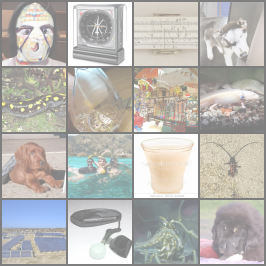

Saved to samples/generated_grid.png


In [18]:
# Cell 7: 샘플링 함수(DDPM/또는 DDIM) 구현
# - timestep_respacing을 "ddim50" 등으로 바꿔 빠르게 샘플 가능(권장)
# - 한 번에 많은 이미지를 생성하지 말고 batch_size를 작게(예: 4) 두고 루프

from guided_diffusion.script_util import create_model_and_diffusion

@torch.no_grad()
def generate_with_classifier_guidance(
    num_samples=16,
    batch_size=4,
    timestep_respacing="ddim50",  # "ddim25", "ddim50", "250"(DDPM) 등
    classifier_scale=1.0,
    use_ddim=True,                # DDIM 권장
):
    # 1) 필요 시 샘플링 전용 diffusion을 timestep_respacing 반영하여 재생성
    #    (아키텍처/학습 스텝은 동일, respacing만 변경)
    mdefs_sampling = model_and_diffusion_defaults()
    mdefs_sampling.update(dict(
        attention_resolutions="32,16,8",
        class_cond=True,
        diffusion_steps=1000,
        dropout=0.1,
        image_size=64,
        learn_sigma=True,
        noise_schedule="cosine",
        num_channels=192,
        num_head_channels=64,
        num_res_blocks=3,
        resblock_updown=True,
        use_new_attention_order=True,
        use_fp16=False,
        use_scale_shift_norm=True,
        timestep_respacing=timestep_respacing,
    ))
    _, diffusion_sampling = create_model_and_diffusion(**mdefs_sampling)

    # 2) 루프를 돌며 이미지를 누적 생성
    imgs_out = []
    remaining = num_samples
    while remaining > 0:
        bs = min(batch_size, remaining)

        # 랜덤 클래스(0..999)로 조건 지정(실전에서는 특정 클래스를 선택 가능)
        classes = th.randint(low=0, high=NUM_CLASSES, size=(bs,), device=DEVICE)
        model_kwargs = dict(y=classes)

        # DDIM/혹은 DDPM 함수 선택
        sample_fn = diffusion_sampling.ddim_sample_loop if use_ddim else diffusion_sampling.p_sample_loop

        # 생성 실행 (출력 범위는 [-1,1])
        sample = sample_fn(
            model_fn,
            (bs, 3, 64, 64),
            clip_denoised=True,
            model_kwargs=model_kwargs,
            cond_fn=lambda x, t, y=None: cond_fn(x, t, y, classifier_scale=classifier_scale),
            device=DEVICE,
            progress=True,
        )
        imgs_out.append(sample.cpu())
        remaining -= bs

    # 3) 배치 리스트를 하나의 텐서로 결합
    return th.cat(imgs_out, dim=0)

# 데모: 16장 생성
samples = generate_with_classifier_guidance(num_samples=16, batch_size=4, timestep_respacing="ddim50", classifier_scale=1.0, use_ddim=True)
show_tensor_grid(samples, nrow=4, title="Generated (classifier-guided, 64x64, DDIM50)")
save_image((make_grid(samples, nrow=4, normalize=True, value_range=(-1,1))+1)/2, "samples/generated_grid.png")
print("Saved to samples/generated_grid.png")

Left: Real | Right: Generated | matched by ImageNet top-1 class (threshold=1.0)


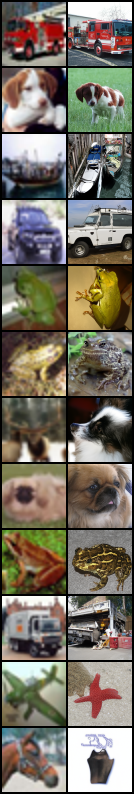

Saved comparison to: samples/real_vs_fake_matched.png


In [26]:
# Cell 8 (수정): 동일 '클래스'로 매칭된 Real vs Generated 시각화
# - 실제 이미지에서 64x64 분류기로 ImageNet class(top-1)를 예측
# - 동일 클래스 라벨로 classifier-guided 샘플 생성
# - 좌: Real, 우: Generated로 나란히 2열 그리드

import torch as th
import torch.nn.functional as F
from torchvision.utils import make_grid, save_image
from PIL import Image
import numpy as np
from IPython.display import display, clear_output
import itertools

@th.no_grad()
def show_real_vs_generated_matched(
    val_loader,
    num_pairs=12,
    timestep_respacing="ddim100",   # 샘플링 스텝 수(속도/품질 트레이드오프)
    classifier_scale=1.0,          # guidance 강도
    use_ddim=True,                 # DDIM 권장
    confidence_threshold=1.0,      # softmax top-1 확률 하한(0.0이면 모든 샘플 사용)
    save_path="samples/real_vs_fake_matched.png",
):
    # 1) 'real' 이미지 배치 획득
    real_batch = next(iter(val_loader))[0].to(DEVICE)  # [-1,1]
    # 필요 개수보다 배치가 작으면 추가 배치를 이어받아도 되고, 여기서는 첫 배치에서만 사용
    if real_batch.shape[0] < num_pairs:
        num_pairs = real_batch.shape[0]

    # 2) 분류기 top-1 클래스 예측 (t = 0: 무노이즈에서의 예측)
    t0 = th.zeros(real_batch.shape[0], dtype=th.long, device=DEVICE)
    logits = classifier(real_batch, t0)           # [B, 1000]
    probs  = F.softmax(logits, dim=-1)            # 확률
    confs, preds = probs.max(dim=-1)              # top-1 확률과 인덱스

    # 3) 신뢰도 기준으로 상위 샘플 선별(옵션)
    #    - CIFAR-10과 ImageNet 분포가 달라서 conf가 낮을 수 있음. threshold를 올리면 짝 수가 줄어듦
    idx_sorted = th.argsort(confs, descending=True)  # 확률 내림차순 인덱스
    selected = []
    for i in idx_sorted.tolist():
        if confs[i].item() >= confidence_threshold:
            selected.append(i)
        if len(selected) >= num_pairs:
            break
    if len(selected) < num_pairs:
        # threshold를 만족하는 샘플이 부족하면 상위 conf로만 채움
        selected = idx_sorted[:num_pairs].tolist()

    real_sel   = real_batch[selected]             # [N, 3, 64, 64]
    class_sel  = preds[selected]                  # [N]

    # 4) 동일 클래스 라벨로 '생성' (classifier-guided)
    #    - Cell 7의 generate_with_classifier_guidance가 랜덤 클래스를 사용하므로,
    #      여기서는 라벨을 직접 지정해 inline으로 샘플링합니다.
    from guided_diffusion.script_util import create_model_and_diffusion, model_and_diffusion_defaults

    # 4-1) 샘플링용 diffusion (timestep_respacing 반영)
    mdefs_sampling = model_and_diffusion_defaults()
    mdefs_sampling.update(dict(
        attention_resolutions="32,16,8",
        class_cond=True,
        diffusion_steps=1000,
        dropout=0.1,
        image_size=64,
        learn_sigma=True,
        noise_schedule="cosine",
        num_channels=192,
        num_head_channels=64,
        num_res_blocks=3,
        resblock_updown=True,
        use_new_attention_order=True,
        use_fp16=False,
        use_scale_shift_norm=True,
        timestep_respacing=timestep_respacing,
    ))
    _, diffusion_sampling = create_model_and_diffusion(**mdefs_sampling)

    # 4-2) DDIM/또는 DDPM 샘플 함수 선택
    sample_fn = diffusion_sampling.ddim_sample_loop if use_ddim else diffusion_sampling.p_sample_loop

    # 4-3) 생성 실행(동일 클래스 y로 조건)
    #      - cond_fn은 scripts/classifier_sample.py와 동일 로직 (Cell 6 정의 사용)
    gen = sample_fn(
        model_fn,
        (len(class_sel), 3, 64, 64),
        clip_denoised=True,
        model_kwargs=dict(y=class_sel.to(DEVICE)),
        cond_fn=lambda x, t, y=None: cond_fn(x, t, y, classifier_scale=classifier_scale),
        device=DEVICE,
        progress=True,
    )  # [-1,1], shape [N,3,64,64]

    # 5) [0,1]로 변환한 뒤, (Real, Generated) 교차로 2열 그리드 구성
    real_01 = (real_sel + 1) / 2
    gen_01  = (gen      + 1) / 2

    pairs = list(itertools.chain.from_iterable(zip(real_01, gen_01)))  # [R0, G0, R1, G1, ...]
    comp = th.stack(pairs, dim=0)
    grid = make_grid(comp, nrow=2, padding=2)

    clear_output(wait=True)
    print(f"Left: Real | Right: Generated | matched by ImageNet top-1 class (threshold={confidence_threshold})")
    display(Image.fromarray((grid.permute(1,2,0).cpu().numpy()*255).clip(0,255).astype(np.uint8)))

    save_image(grid, save_path)
    print(f"Saved comparison to: {save_path}")

# 실행 예시: 신뢰도 임계값 없이 상위 확률 순으로 12쌍 매칭
show_real_vs_generated_matched(
    val_loader=val_loader,
    num_pairs=12,
    timestep_respacing="ddim100",
    classifier_scale=1.0,
    use_ddim=True,
    confidence_threshold=1.0,  # 0.2~0.5로 높이면 더 “그럴듯한” 매칭만 사용
    save_path="samples/real_vs_fake_matched.png",
)

- 현재 파이프라인은 “실제 이미지 → 64x64 분류기(top-1 예측) → 동일 라벨로 생성(가이던스)” 흐름입니다.
  
 - 위치·포즈 차이는 “classifier guidance” 특성상 자연스럽습니다(구성·레이아웃까지 고정하지 않음). 본 단계에서는 “명백히 다른 카테고리”가 매칭되는 케이스를 confidence로 걸러내 품질을 높이는 데 초점을 둡니다.

Left: Real | Right: Generated (same predicted ImageNet class, scale=1.0, respacing=ddim50)


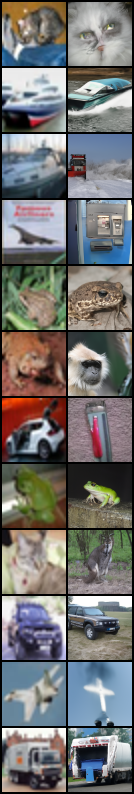

Saved comparison grid to: samples/real_vs_fake_matched.png


In [20]:
# Real vs Generated (Matched by predicted ImageNet class) Visualization Cell
# - 전제: 다음 객체/함수/모듈이 상단 셀에서 이미 준비되어 있어야 합니다.
#   DEVICE, model, classifier
#   model_and_diffusion_defaults, create_model_and_diffusion
#   make_grid, save_image, Image, display, clear_output
#   val_loader (CIFAR-10 64x64 [-1,1] 정규화), NUM_CLASSES
#   cond_fn, model_fn (classifier guidance 구현)
# - 목적: 각 "실제 이미지"에 대해 분류기가 예측한 ImageNet 클래스(y_pred)로
#        동일 클래스의 "생성 이미지"를 만들어 1:1로 정확히 매칭해 시각화.

import torch as th
import itertools
import numpy as np
from PIL import Image
from IPython.display import display, clear_output
from torchvision.utils import make_grid, save_image
from guided_diffusion.script_util import model_and_diffusion_defaults, create_model_and_diffusion

@th.no_grad()
def compare_real_vs_generated_matched(
    val_loader,
    num_pairs=12,                  # 비교 쌍 개수
    timestep_respacing="ddim50",   # 샘플링 스텝(DDIM 권장: "ddim25"/"ddim50"/"ddim100"...)
    classifier_scale=1.0,          # guidance 강도
    use_ddim=True,                 # DDIM/DDPM 선택
    save_path="samples/real_vs_fake_matched.png",
):
    # 0) 재현성(선택): 시드 고정
    # th.manual_seed(42)
    # if th.cuda.is_available(): th.cuda.manual_seed_all(42)

    # 1) Real 이미지 로드 (CIFAR-10 검증셋에서 num_pairs개)
    real_batch = next(iter(val_loader))[0][:num_pairs].to(DEVICE)  # [-1,1], shape: [N,3,64,64]

    # 2) 분류기로 ImageNet 클래스 y_pred 추정 (t=0에서 분류)
    #    classifier는 (x, t)를 입력으로 받음. t=0은 "무잡음" 상태.
    t0 = th.zeros(num_pairs, dtype=th.long, device=DEVICE)         # [N]
    logits = classifier(real_batch, t0)                             # [N, 1000]
    y_pred = logits.argmax(dim=-1)                                  # [N], 각 이미지의 ImageNet 클래스 ID
    #   참고: CIFAR 라벨과 다릅니다. 여기서는 분류기의 ImageNet 예측 클래스로 "동일 클래스"를 정의합니다.

    # 3) 샘플링용 diffusion 인스턴스(동일 아키텍처 + respacing만 변경) 준비
    mdefs_sampling = model_and_diffusion_defaults()
    mdefs_sampling.update(dict(
        attention_resolutions="32,16,8",
        class_cond=True,
        diffusion_steps=1000,
        dropout=0.1,
        image_size=64,
        learn_sigma=True,
        noise_schedule="cosine",
        num_channels=192,
        num_head_channels=64,
        num_res_blocks=3,
        resblock_updown=True,
        use_new_attention_order=True,
        use_fp16=False,
        use_scale_shift_norm=True,
        timestep_respacing=timestep_respacing,  # ← 여기만 샘플링 스텝 단축/조절
    ))
    _, diffusion_sampling = create_model_and_diffusion(**mdefs_sampling)

    # 4) 한 번에 num_pairs개를 "예측 클래스 y_pred"로 생성
    sample_fn = diffusion_sampling.ddim_sample_loop if use_ddim else diffusion_sampling.p_sample_loop
    samples = sample_fn(
        model_fn,                               # class_cond 모델 호출용 래퍼
        (num_pairs, 3, 64, 64),                 # 출력 텐서 크기
        clip_denoised=True,
        model_kwargs={"y": y_pred},             # ← 핵심: 각 Real의 예측 클래스와 동일한 라벨로 생성
        cond_fn=lambda x, t, y=None: cond_fn(x, t, y, classifier_scale=classifier_scale),
        device=DEVICE,
        progress=True,
    )
    # samples: [-1,1], shape [N,3,64,64]

    # 5) 2열(좌: Real, 우: Generated) 그리드로 묶어 시각화/저장
    real_01 = (real_batch + 1) / 2
    fake_01 = (samples + 1) / 2

    # Real0, Gen0, Real1, Gen1, ... 순서로 쌓기
    pairs = list(itertools.chain.from_iterable(zip(real_01.cpu(), fake_01.cpu())))
    comp = th.stack(pairs, dim=0)               # [2*N,3,64,64]

    grid = make_grid(comp, nrow=2, padding=2)   # 2열: (Left=Real, Right=Generated)
    clear_output(wait=True)
    print(f"Left: Real | Right: Generated (same predicted ImageNet class, scale={classifier_scale}, respacing={timestep_respacing})")
    display(Image.fromarray((grid.permute(1,2,0).numpy()*255).clip(0,255).astype(np.uint8)))

    save_image(grid, save_path)                 # grid는 이미 [0,1] 범위
    print(f"Saved comparison grid to: {save_path}")


# 실행 예시:
# 비교 쌍 12개, DDIM 50스텝, guidance scale=1.0
compare_real_vs_generated_matched(
    val_loader=val_loader,
    num_pairs=12,
    timestep_respacing="ddim50",
    classifier_scale=1.0,
    use_ddim=True,
    save_path="samples/real_vs_fake_matched.png",
)